# Neural Networks Learning

Week5のニューラルネットワークの学習について

In [1]:
import math, random
import numpy as np
import scipy.io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
sns.set_style('whitegrid')

import sys, os
sys.path.append(os.path.dirname('../common/'))
from common import *

default_figsize = plt.rcParams['figure.figsize']

## Visualizing the data

In [2]:
dataset = scipy.io.loadmat('ex4data1.mat')
xs = dataset['X'].tolist()
ys = dataset['y'].ravel().tolist()
ys = [0 if y == 10 else y for y in ys] # y=10はy=0に置き換える

train_frame = pd.DataFrame(data={'image':xs, 'label':ys})

In [3]:
# ランダムに抽出して表示
ixs = sorted(np.random.randint(0, len(train_frame['label']), 20))
train_frame.take(ixs)

,image,label
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
178,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
230,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
581,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
837,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
837,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
1590,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
1595,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
2114,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
2337,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4


In [4]:
def display_data(images, labels):
    m = len(labels)
    rows = math.floor(math.sqrt(m))
    columns = math.ceil(m / rows)

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.7)

    for row in range(rows):
        for col in range(columns):
            index = row * columns + col
            ax = fig.add_subplot(rows, columns, index+1)
            ax.axis('off')
            ax.set_title(labels[index])
            ax.imshow(np.array(images[index]).reshape(20,20).T,
                      cmap=plt.get_cmap('gray'))

saved assets/week05_dataset.png


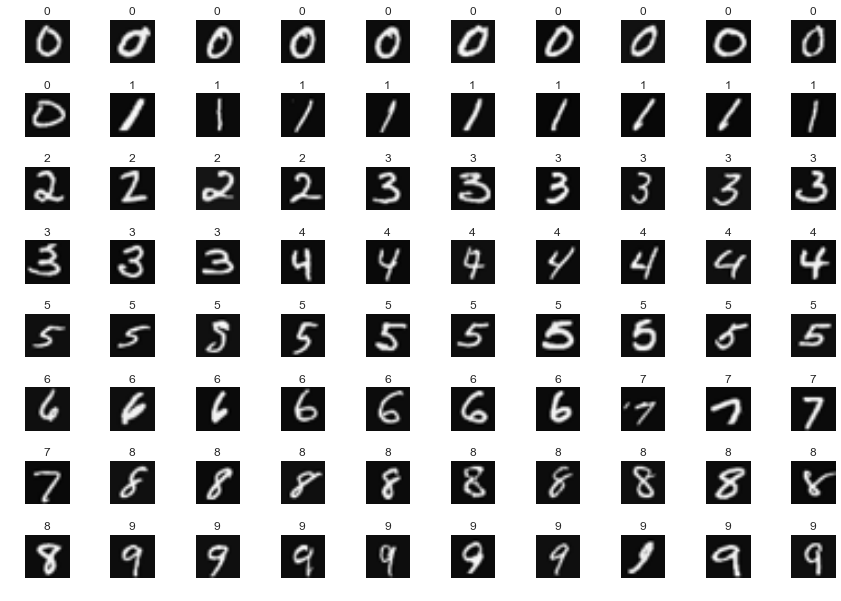

In [5]:
ixs = sorted(np.random.randint(0, len(train_frame['label']), 80))
rand_frame = train_frame.take(ixs)
images = rand_frame['image'].values
labels = rand_frame['label'].values

plt.rcParams['figure.figsize'] = (15, 10)
display_data(images, labels)
savefig('week05_dataset.png')

## Model representation

In [6]:
X = np.array(train_frame['image'].values.tolist())
y = np.array(train_frame['label'].values.tolist()).reshape(-1, 1)

X.shape, y.shape

((5000, 400), (5000, 1))

## Cost function and Gradient Checking

In [7]:
%run 'nn_learning.py'

In [8]:
sigmoid_gradient(np.array([-1.0, -0.5, 0, 0.5, 1.0]))

array([ 0.19661193,  0.23500371,  0.25      ,  0.23500371,  0.19661193])

In [9]:
def _cost_function(num_input_unit, num_hidden_unit, num_labels, X, y, lmd):
    def _func(thetas):
        nonlocal num_input_unit, num_hidden_unit, num_labels, X, y, lmd
        theta1, theta2 = reshape_theta(thetas, num_input_unit, num_hidden_unit, num_labels)
        return cost_function(theta1, theta2, X, y, lmd)
    return _func

In [10]:
_m = 5
_num_input = 2
_num_hidden = 4
_num_labels = 3

_init_theta1 = rand_initialize_weights((_num_hidden, _num_input+1))
_init_theta2 = rand_initialize_weights((_num_labels, _num_hidden+1))
_X = rand_initialize_weights((_m, _num_input))
_y = np.array([k % _num_labels for k in range(_m)]).reshape(-1, 1)

_init_thetas = flatten_theta(_init_theta1, _init_theta2)
_approx_grads = compute_numerical_gradient(_cost_function(_num_input, _num_hidden, _num_labels, _X, _y, 3.), _init_thetas)

_J, _D1, _D2 = _cost_function(_num_input, _num_hidden, _num_labels, _X, _y, 3.)(_init_thetas)
_grads = flatten_theta(_D1, _D2)

# 1e-9よりも小さければOK
np.linalg.norm(_approx_grads - _grads) / np.linalg.norm(_approx_grads + _grads)

2.2118911250938168e-11

## Backpropagation and Learning

In [11]:
num_input_unit  = X.shape[1]
num_hidden_unit = 25
num_labels      = len(np.unique(y))

initial_theta1 = rand_initialize_weights((num_hidden_unit, num_input_unit+1))
initial_theta2 = rand_initialize_weights((num_labels, num_hidden_unit+1))

theta1, theta2, J_history = optimize_params(initial_theta1, initial_theta2, X, y, 1.)

         Current function value: 0.431724
         Iterations: 50
         Function evaluations: 112
         Gradient evaluations: 112


saved assets/week05_cost_history.png


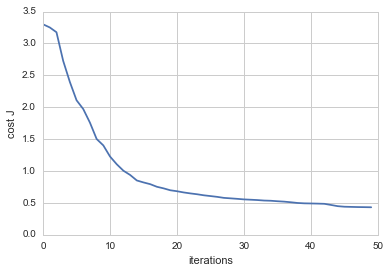

In [12]:
plt.rcParams['figure.figsize'] = default_figsize

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(J_history)
ax.set_xlabel('iterations')
ax.set_ylabel('cost J')
savefig('week05_cost_history.png')

## Prediction

In [13]:
preds = predict(theta1, theta2, X)
pred_classes = np.array([p['class'] for p in preds]).reshape(-1, 1)
pred_values = np.array([p['values'] for p in preds]).reshape(pred_classes.shape[0], -1)
pred_max_values = np.array([max(p) for p in pred_values]).reshape(-1, 1)

compute_train_accuracy(pred_classes, y)

96.519999999999996

In [14]:
corrects = (np.where(pred_classes == y))[0]
mistakes = (np.where(pred_classes != y))[0]

saved assets/week05_mistakes.png


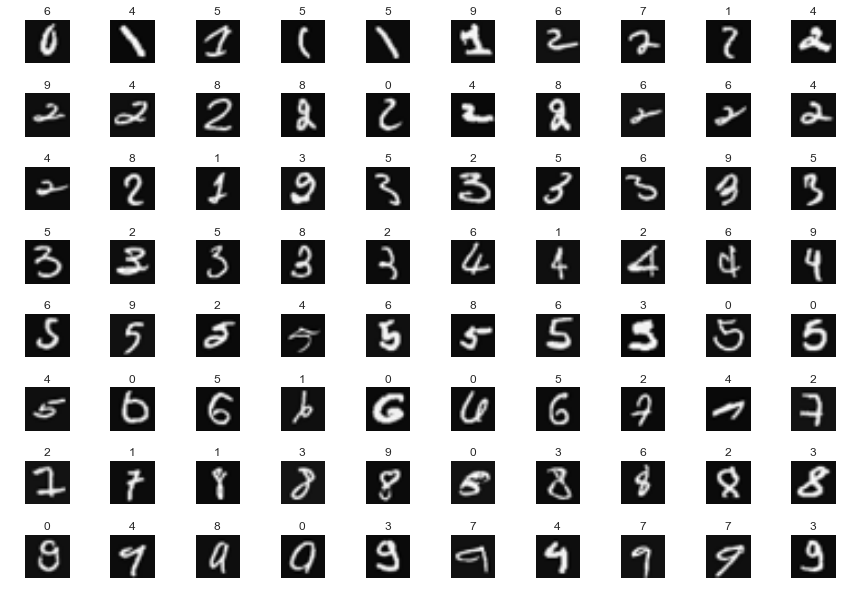

In [15]:
ixs = sorted(np.random.permutation(mistakes)[0:80])
mistake_frame = train_frame.take(ixs)
images = mistake_frame['image'].values
labels = pred_classes[ixs].ravel().tolist()

plt.rcParams['figure.figsize'] = (15, 10)
display_data(images, labels)
savefig('week05_mistakes.png')

saved assets/week05_pred_hist.png


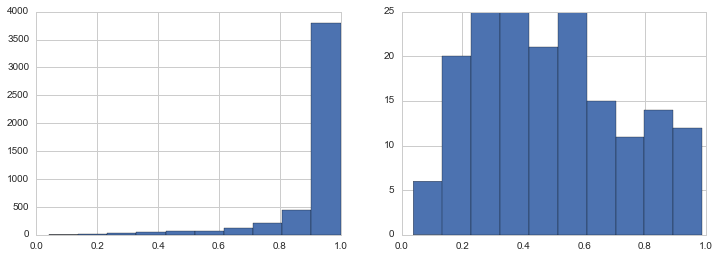

In [16]:
plt.rcParams['figure.figsize'] = (12.0, 4.0)
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax.hist(pred_max_values[corrects])
ax = fig.add_subplot(1,2,2)
ax.hist(pred_max_values[mistakes])
savefig('week05_pred_hist.png')